# Подключение библиотеки

In [81]:
# Уведомление о завершение работы определенного ячейка (очень пригодится для машинного обучения)
import jupyternotify
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [82]:
# Подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Для визуализации временных рядов
import plotly.graph_objects
import seaborn as sb
from scipy import stats as st
# Время обучения модели
import timeit
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson
# XGBRegressor
import xgboost as xgb

# Работа с текстами
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from lightgbm import LGBMRegressor
# Вызов библиотеки для отключения предупреждения
import warnings

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit
# Применим кроссвалидацию для повышения качеств обучения



# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Для машинного обучения разными способами:
# - Логическая регрессия
from sklearn.linear_model import LogisticRegression
# - Случайный лес
from sklearn.ensemble import RandomForestClassifier
# - Решающее дерево
from sklearn.tree import DecisionTreeClassifier
# - Модель на адекватность
from sklearn.dummy import DummyClassifier
# - Бустинг модель
from catboost import CatBoostClassifier

from sklearn.metrics import (
    # Точность модели
    accuracy_score,
    # Матрицы ошибок (для борьбы с дисбалансом)
    confusion_matrix, 
    # Полнота
    recall_score, 
    # Точность
    precision_score, 
    # F1-мера
    f1_score,
    # Метрика AUC-ROC
    roc_auc_score,
    roc_curve,
    # MSE
    mean_squared_error,
    mean_absolute_error,
    fbeta_score, 
    make_scorer
)

# Контроль выборки
from sklearn.utils import shuffle

# Для лематизации текстов
import re
from pymystem3 import Mystem

# Для машинного обучения - деление выборки на обучающие и валидационные
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Просмотр все значений метрики
from sklearn.metrics import classification_report

from sklearn import svm
import joblib

Для машинного обучения с BERT

In [83]:
import os
import shutil
import torch

# Библиотеки для обучения с применением технологий BERT
import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as text
from transformers import BertTokenizer
# Чтобы создать AdamW оптимизацию
from official.nlp import optimization  

tf.get_logger().setLevel('ERROR')

In [84]:
# Получаем датасет
try:
    # С локального файла
    try:
        # Сразу устанавливаем время как индексы
        df = pd.read_csv('toxic_comments.csv', index_col=[0], parse_dates=[0])
    except:
        df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0], parse_dates=[0])
except:
    print('Отсутствует датасет. Проверьте путь файла')

# Предобработка данных

## Разделим на обучающую и тестовую выборку

In [15]:
# Деление обучающей выборки на признаки и целевые признаки
features = df['text']
target = df['toxic']

In [16]:
# Разделим обучающую и тестовую выборку
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [17]:
print('Размер обучающей выборки:', round(features_train.shape[0] / df.shape[0], 3), '%')
print('Размер тестовой выборки:', round(features_test.shape[0] / df.shape[0], 3), '%')

Размер обучающей выборки: 0.75 %
Размер тестовой выборки: 0.25 %


## Корпусы текстов

In [18]:
# Создаем корпус текстов
corpus_train = list(features_train)
corpus_test = list(features_test)

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Приводить тексты к юникоду не имеет смысла, так как они все на английском. Это может привести к падению ядра из-за увеличения объема занимаемой памяти.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента V2:</b> Хорошо, подправил
</div>

In [19]:
print('Corpus_train')
display(corpus_train[0])
print()
print('Corpus_test')
display(corpus_test[0])

Corpus_train


"That makes no sense. You don't play MapleStory through Internet Explorer. Sure, the website can only be accessible through IE (well, you can access it through Firefox as well if you know what to do), but it's not really part of the game."


Corpus_test


'Expert Categorizers  \n\nWhy is there no mention of the fact that Nazis were particularly great categorizers? They excelled in identifying various things and writing about them and putting them in their proper places.'

## Установка стоп-слово

In [20]:
# Получим стоп-слово
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Papin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Создание корпуса текстов с обучающей и тестовой выборки

### Обучающая выборка

In [21]:
# По аналогии с CountVectorizer() создадим счётчик, указав в нём стоп-слова:
count_tf_idf_train = TfidfVectorizer(stop_words=list(stopwords))

In [22]:
# Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform():
tf_idf_train = count_tf_idf_train.fit_transform(corpus_train) 
# Передав TfidfVectorizer() аргумент ngram_range, можно рассчитать N-граммы.

In [23]:
print("Размер матрицы обучающей выборки:", tf_idf_train.shape)

Размер матрицы обучающей выборки: (119469, 158310)


### Тестовая выборка

In [24]:
# По аналогии с CountVectorizer() создадим счётчик, указав в нём стоп-слова:
count_tf_idf_test = TfidfVectorizer(stop_words=list(stopwords))

In [25]:
# Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform():
tf_idf_test = count_tf_idf_train.transform(corpus_test) 
# Передав TfidfVectorizer() аргумент ngram_range, можно рассчитать N-граммы.

In [26]:
print("Размер матрицы тестовой выборки:", tf_idf_test.shape)

Размер матрицы тестовой выборки: (39823, 158310)


# Машинное обучение с BERT

In [85]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [86]:
torch.cuda.is_available()

False

In [87]:
tf_idf_train.shape[0]

119469

In [88]:
%%time
from tqdm import notebook
batch_size = 2 # для примера возьмем такой батч, где будет всего две строки датасета
embeddings = [] 

CPU times: total: 0 ns
Wall time: 0 ns


In [29]:
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

In [30]:
device

device(type='cpu')

In [31]:
%%time
for i in notebook.tqdm(range(tf_idf_train.shape[0] // batch_size)):
        batch = torch.LongTensor(tf_idf_train[batch_size*i:batch_size*(i+1)]).cuda() # закидываем тензор на GPU
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()

        with torch.no_grad():
            model.cuda()
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) # перевод обратно на проц, чтобы в нумпай кинуть
        del batch
        del attention_mask_batch
        del batch_embeddings

  0%|          | 0/59734 [00:00<?, ?it/s]

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [ ]:
features = np.concatenate(embeddings) 

## Получение датасета

In [32]:
# Получаем csv файл через ссылки
toxic_comments_path = tf.keras.utils.get_file("toxic_comments.csv", 'https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [33]:
# Адрес хранения csv файла
toxic_comments_path

'C:\\Users\\Papin\\.keras\\datasets\\toxic_comments.csv'

In [34]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

toxic_comments_csv_ds = tf.data.experimental.make_csv_dataset(
    'toxic_comments.csv',
    label_name='',
    batch_size=batch_size,
    num_epochs=1,
    ignore_errors=True)

Просмотр текстов

In [35]:
for batch, label in toxic_comments_csv_ds.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value}")
        print('-'*127)
    print('='*127)
    print('')
    print(f"{'label':20s}: {label}")

text                : [b'"|decline=You felt it necessary to repeatedly make this edit, which is considered vandalism. \xe2\x80\x94 \\\xc2\xa0talk\xc2\xa0/ }}"'
 b"Current Events Story\nHi, I removed the story you posted on Cuurent Events for several reasons:\n The story didn't seem to belong on the date where you placed it. If the story was reported in a newspaper dated January 13th, it shouldn't be listed under the January 20th events.\n I know this may be an important story in Belize, but (as far as I can tell) only one newspaper is carrying it and there are no hits on Google News. It doesn't appear to be of global importance, which is usually what it takes to be included on Current Events.\n The summary was way too long. Two or three sentences is usually the maximum for a summary. If it wasn't for the first two points, I would have attempted to edit the summary instead of deleting. \n\nFor now, I'm going to remove the story, but if you can find more sources, please feel free to incl

In [36]:
toxic_comments_csv_ds

<PrefetchDataset element_spec=(OrderedDict([('text', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('toxic', TensorSpec(shape=(None,), dtype=tf.int32, name=None))]), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

##  Деление на обучающей и тестовой выборки

In [37]:
# Разделим обучающую и валидцаионную, тестовую выборку в соотношение 60:40
train, test = train_test_split(df, test_size=0.2, random_state=12345)

In [38]:
print('Размер обучающей выборки:', round(train.shape[0] / df.shape[0], 3), '%')
print('Размер тестовой выборки:', round(test.shape[0] / df.shape[0], 3), '%')

Размер обучающей выборки: 0.8 %
Размер тестовой выборки: 0.2 %


In [39]:
# Cохраняим файлы
train.to_csv(r"toxic_comments_train.csv")
test.to_csv(r"toxic_comments_test.csv")

In [40]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

toxic_comments_csv_ds_train = tf.data.experimental.make_csv_dataset(
    'toxic_comments_train.csv',
    label_name='',
    batch_size=batch_size,
    num_epochs=1,
    ignore_errors=True)

toxic_comments_csv_ds_test = tf.data.experimental.make_csv_dataset(
    'toxic_comments_test.csv',
    label_name='',
    batch_size=batch_size,
    num_epochs=1,
    ignore_errors=True)

Просмотр текстов обучающей выборки

In [41]:
for batch, label in toxic_comments_csv_ds_train.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value}")
        print('-'*127)
    print('='*127)
    print('')
    print(f"{'label':20s}: {label}")

text                : [b"Mooriddengirl: I'd appreciate it if you would unblock me or leave a note to allow another administrator to unblock me.  I've followed all the Wikipedia suggestions and I have apologized, I've stated I won't do it again, and I'd like you and the others to show good faith towards me.  Thanks"
 b"Rookie Award \n\nOn 14 July, it was announced that EXO has won 2012 Best Rookie Award of Japan's Tower Records 'K-Pop Lovers! Award'. Tower Records is the largest music store in Japan.\n\nJapan's Tower Records reported the results which combines internet users' vote and album sales in Japan from January of this year till June. Their debut album MAMA recorded over 100,000 copies sales in just two months. The grand total of the album placed the group to become the biggest selling rookie in 2012 so far."
 b"Bushranger you're a GRASS with no sense of humour. Seen the South Park episode Poor and Stupid? That's what I was referring to, a comment obviously lost on you. But you'v

Просмотр текстов тестовой выборки

In [42]:
for batch, label in toxic_comments_csv_ds_test.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value}")
        print('-'*127)
    print('='*127)
    print('')
    print(f"{'label':20s}: {label}")

text                : [b"Re:Bonjour! \nHow did you know I'm taking French classes? That really helps, please keep going. I'm not editing articles too much, school and this are taking up my time. I'm glad to see you've returned, Fred. I missed you."
 b"Do you actually believe in such a fairy tale?  The guy has been living in the US for half of his life and he doesn't have a US citizenship?  Cmon, use your common sense.  Do you actually believe he's been applying for his green card over and over?  It would be much easier if he had owned any companies in the US and didn't he own half of the Coyotes?"
 b", 12 April 2007 (UTC)\nTabloids can be accurate sources - sometimes. Occasionally. Rarely, even. Show us a link! Our local paper usually picks up on absurd British stories, but I haven't heard of this one over here in AU.  02:00"
 b'WHY U ALL DELETIN MY PAGES DOG?'
 b'"\n\n This is an interesting discussion with good points made by all. I can add a little bit that might be helpful. As ment

## Загрузка моделей с TensorFlow HUB

In [89]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Модель предварительной обработки

In [90]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

FileNotFoundError: Op type not registered 'CaseFoldUTF8' in binary running on ALEXEY. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [46]:
corpus_train[0]

"That makes no sense. You don't play MapleStory through Internet Explorer. Sure, the website can only be accessible through IE (well, you can access it through Firefox as well if you know what to do), but it's not really part of the game."

In [47]:
text_test = list(corpus_train[0])
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

NameError: name 'bert_preprocess_model' is not defined

### Возвращаемые значения

Прежде чем внедрять BERT в вашу собственную модель, нужно сначала взглянуть на ее выходные данные. 

Мы загрузили его из TF Hub, и теперь увидим возвращаемые значения.

In [447]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [448]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(463, 512)
Pooled Outputs Values:[ 0.964834   -0.17843105 -0.25604504 -0.08633736  0.06525536  0.96364266
  0.76323825 -0.8259036  -0.25786063 -0.9997027   0.15350132 -0.99833673]
Sequence Outputs Shape:(463, 128, 512)
Sequence Outputs Values:[[ 1.1880465   0.16548514  0.52010137 ... -1.3935456   0.72548085
   0.4851817 ]
 [ 1.8258715   0.6981835  -0.92007947 ...  0.02137677  1.1609669
   0.11297412]
 [ 1.3568974  -0.37145764  1.0243483  ... -0.6833948   0.30857855
   0.20199293]
 ...
 [ 0.8787285  -0.02032542 -0.4496386  ... -0.18110166  0.92780066
   0.22329672]
 [ 0.87346816  0.26692882 -0.26071578 ... -0.20293932  1.0134312
   0.07956394]
 [ 0.87515575  0.36114353 -0.38098806 ... -0.17099996  0.94220555
   0.06431089]]


**ЛУЧШИЕ модели** возвращают карту с 3 важными ключами: `pooled_output`, `sequence_output`, `encoder_outputs`:

`pooled_output` представляет каждую входную последовательность в целом. Форма - `[batch_size, H]`. Мы можем рассматривать это как встраивание для всего обзора фильма.

`sequence_output` представляет каждый входной токен в контексте. Форма имеет вид `[batch_size, seq_length, H]`. Мы можем думать об этом как о контекстуальном встраивании для каждого токена в обзоре фильма.

`encoder_outputs` - это промежуточные активации блоков `L`-трансформатора. выходные данные `["encoder_outputs"][i]` - это тензор формы `[batch_size, seq_length, 1024]` с выходами i-го блока преобразования, для `0 <= i < L`. Последнее значение списка равно `sequence_output`.

Для точной настройки мы используем массив `pooled_output`.

### Подбор моделей для машинного обучения

Мы создадим очень простую точно настроенную модель с моделью предварительной обработки, выбранной **НАИЛУЧШЕЙ моделью**, одним плотным слоем и отсеивающимся слоем.

_*Примечание:*_ 
для получения дополнительной информации о вводе и выводе базовой модели мы можем перейти по URL модели для получения документации. 

Конкретно здесь нам не нужно беспокоиться об этом, потому что модель предварительной обработки позаботится об этом за нас.

In [449]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

Проверим, что модель запускается с выводом модели предварительной обработки

In [450]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.3348399 ]
 [0.2792921 ]
 [0.4259739 ]
 [0.31419381]
 [0.40028316]
 [0.2792921 ]
 [0.32369584]
 [0.3770468 ]
 [0.3607976 ]
 [0.30364728]
 [0.4259739 ]
 [0.2792921 ]
 [0.47554448]
 [0.3770468 ]
 [0.5338048 ]
 [0.3770468 ]
 [0.30364728]
 [0.3770468 ]
 [0.3452456 ]
 [0.3404307 ]
 [0.2792921 ]
 [0.3770468 ]
 [0.30364728]
 [0.2792921 ]
 [0.3770468 ]
 [0.3404307 ]
 [0.47301543]
 [0.43304822]
 [0.46185058]
 [0.47554448]
 [0.40028316]
 [0.47554448]
 [0.4089541 ]
 [0.2792921 ]
 [0.3603921 ]
 [0.46185058]
 [0.4259739 ]
 [0.2792921 ]
 [0.3452456 ]
 [0.3404307 ]
 [0.43304822]
 [0.4262962 ]
 [0.2792921 ]
 [0.32369584]
 [0.3452456 ]
 [0.3607976 ]
 [0.2792921 ]
 [0.4262962 ]
 [0.40028316]
 [0.28023177]
 [0.3607976 ]
 [0.30364728]
 [0.2792921 ]
 [0.36923188]
 [0.31419381]
 [0.40028316]
 [0.3404307 ]
 [0.2792921 ]
 [0.3770468 ]
 [0.4259739 ]
 [0.2792921 ]
 [0.36923188]
 [0.28023177]
 [0.30364728]
 [0.2792921 ]
 [0.4259739 ]
 [0.31419381]
 [0.40028316]
 [0.2792921 ]
 [0.4259739 ]
 [0.34524

Выходные данные бессмысленны, потому что модель еще не была обучена

## Машинное обучение

Теперь у нас есть все компоненты для обучения модели, включая модуль предварительной обработки, кодировщик BERT, данные и классификатор

### Функция потерь

Поскольку это задача двоичной классификации, и модель выдает вероятность (единичный уровень), вы будете использовать функцию потерь `losses.BinaryCrossentropy`.


In [451]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Оптимизация

Для точной настройки воспользуемся тем же оптимизатором, с которым изначально обучался БЕРТ: "Адаптивные моменты" (Adam). Этот оптимизатор минимизирует потери при прогнозировании и выполняет регуляризацию путем уменьшения веса (без использования моментов), которая также известна как [AdamW](https://arxiv.org/abs/1711.05101 ).

Для скорости обучения (`init_lr`) будем использовать тот же график, что и для предварительной тренировки BERT: линейное уменьшение условной начальной скорости обучения с префиксом линейной фазы разминки в течение первых 10% шагов обучения (`num_warmup_steps`). В соответствии с ЛУЧШЕЙ статьей, начальная скорость обучения меньше для точной настройки (лучше всего 5e-5, 3e-5, 2e-5).

In [452]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(toxic_comments_csv_ds_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

### Загружаем модель BERT и обучаем ее

Используя `classifier_model`, который мы создали ранее, мы можете скомпилировать модель с потерями, метрикой и оптимизатором.

In [453]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Примечание: время обучения будет варьироваться в зависимости от сложности выбранной вами модели BERT.

In [454]:
print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(x=toxic_comments_csv_ds, validation_data=val_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
    883/Unknown - 2586s 3s/step - loss: -1653.4751 - binary_accuracy: 0.0000e+00

KeyboardInterrupt: 

<div class="alert alert-block alert-info">

Комментарий студента V1: У меня вопрос к ревью. Я сделал примерно то, что было по образцу с вебинара. Но здесь не указан конец шага, т.е. там вместо числа стоит `Unknown`. Получается, что здесь будет бесконечная итерация
    
</div>

<div class="alert alert-block alert-info">

<b>Совет: </b> https://datascience.stackexchange.com/questions/74168/epoch-1-5-wont-stop
</div>

<div class="alert alert-block alert-info">

<b>Совет: </b> Вообще говоря, лучше использовать torch. Он намного более популярен сейчас. Вот специализированный БЕРТ для него: https://huggingface.co/unitary/toxic-bert
</div>

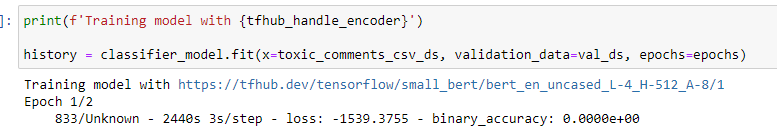

### Оценка моделей

In [455]:
loss, accuracy = classifier_model.evaluate(toxic_comments_csv_ds_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

     54/Unknown - 40s 716ms/step - loss: -5944.1006 - binary_accuracy: 0.0000e+00

KeyboardInterrupt: 

<div class="alert alert-block alert-info">

Комментарий студента V1: И здесь аналогично
    
</div>

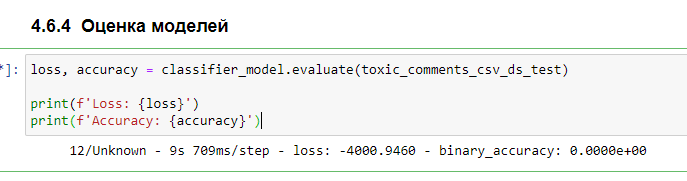

### Построим график точности и потери с течением времени

На основе объекта `History`, возвращаемого `model.fit()`. Вы можете построить график потерь при обучении и валидации для сравнения, а также точности обучения и валидации:

In [456]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

NameError: name 'history' is not defined

## Проверим на F1-метрику

In [504]:
# Каким образом можно вытянуть предсказания, если там выдает только функцию потери?

In [505]:
# В процессе